In [1]:
# unwrap archive cache file
archive_wandb_cache_file = 'wandb_cost_df_cache.pkl.gz'

import gzip

# ungzip the file
with gzip.open(archive_wandb_cache_file, 'rb') as f:
    with open('wandb_cost_df_cache.pkl', 'wb') as f2:
        f2.write(f.read())

In [2]:
import os

import wandb
from collections import defaultdict

api = wandb.Api()

datasets = ['airline', 'imdb', 'ssb', 'tpc_h', 'walmart', 'financial', 'basketball', 'accidents', 'movielens',
            'baseball', 'hepatitis', 'tournament', 'genome', 'credit', 'employee', 'carcinogenesis', 'consumer',
            'geneea', 'seznam', 'fhnk']

wandb_project = 'jwehrstein/udf_cost_estimation'


def get_table_df(url: str, label: str):
    artifact = api.artifact(url)
    artifact.download()
    table = artifact.get(label)
    return table.get_dataframe()


def extract_dataset_from_name(name: str):
    candidates = []
    for dataset in datasets:
        if f'_{dataset}_' in name:
            candidates.append(dataset)

    assert len(candidates) == 1, f'Found {len(candidates)} candidates for {name}'
    return candidates[0]

wandb_cache_file = 'wandb_cost_df_cache.pkl'

if os.path.exists(wandb_cache_file):
    import pickle

    with open(wandb_cache_file, 'rb') as f:
        df_cache = pickle.load(f)
        print(f'Loaded {len(df_cache)} entries from cache')
else:
    df_cache = dict()

def get_dataframes_from_run(run: str):
    if run in df_cache:
        print(f'Found run {run} in cache')
        return df_cache[run]

    df_dict = defaultdict(dict)

    instance = api.run(f'{wandb_project}/{run}')
    # print(instance.summary.keys())
    dataset = extract_dataset_from_name(instance.displayName)

    if wandb.run is None:
        run = wandb.init()

    assert wandb.run is not None

    for test_file in ['workload_no_udf', 'workload_pullup', 'workload_pushdown', 'workload_intermed']:
        for card in ['act', 'est', 'dd', 'wj']:
            if f'{test_file}_{card}' not in instance.summary.keys():
                print(f'Artifact {test_file}_{card} not found in run {run} (dataset: {dataset})')
                continue

            artifact_url = f'{wandb_project}/run-{run}-{test_file}_{card}test_{test_file}_{card}_data:latest'
            df_dict[test_file][card] = get_table_df(artifact_url, f'{test_file}_{card}.test_{test_file}_{card}_data')

    df_cache[run] = dataset, df_dict

    # save cache to file
    import pickle
    with open(wandb_cache_file, 'wb') as f:
        pickle.dump(df_cache, f)

    return dataset, df_dict

Loaded 45 entries from cache


In [3]:
from models.training.metrics import QError
import pandas as pd

# runs list - list of run ids

# paper runs - GRACEFUL default (with intermed pos)
runs = [
    'p21n20c3', # tournament
    '6k58we9v', # fhnk
    '4px8jbz8', # airline
    'r4v4u902', # basketball
    '3qawe78v', # movielens
    'yigoi5yx', # walmart
    '3mmq2tpg', # hepatitis
    'mqi2m1zj', # genome
    'mq9sp978', # ssb
    'em52kdey', # consumer
    'q4plxvkc', # credit
    'gwkbiq1i', # seznam
    'cgpgmz1b', # genome
    'gtdckbi5', # hepatitis
    'ys3i3kwi', # movielens
    'ljrgwl4g', # basketball
    'vbtqlmlx', # tournament
    'yvd7qiwa', # fhnk
    'uhgmmp0a', # consumer
    'fgydoqzf', # walmart
]


# hybrid: FlatVector (UDF) + Graceful (SQL) (with intermed pos)
# runs = [
#     'ru72owix', # hepatitis
#     'n44e5fl5', # geneea
#     'qifeyt0w', # financial
#     'tz39bq3m', # carcinogenesis
#     'ihp3cns2', # movielens
#     'rezde0sk', # seznam
#     '864iv1ko', # tournament
#     'yfwt6wsp', # accidents
#     '58krxplh', # imdb
#     'gafn8n49', # credit
#     'urbwj2vm', # ssb
#     'jja0s14c', # walmart
#     'r9dwd6wl', # consumer
#     'gt6an961', # genome
#     '8s7cxcet', # tpc_h
#     'wryhgu0u', # fhnk
#     '5pz9dxgr', # employee
#     'lvwjdgq9', # basketball
#     'exalf57s', # baseball
#     'dukv5gdv', # airline
# ]


# initialize dictionaries
run_dict = dict()
#wb_run = wandb.init()
for i, r in enumerate(runs):
    print(f'Processing run {r}: {i + 1}/{len(runs)}')
    try:
        dataset, run_data = get_dataframes_from_run(r)
    except Exception as e:
        print(e)
        continue

    run_dict[dataset] = run_data
    
def combine_dataframes_by_card_and_dataset(run_dict, include_no_udf: bool = False):
    df_card_dict = defaultdict(dict)
    df_card_dict_by_file = defaultdict(dict)

    for dataset, run_data in run_dict.items():
        for test_file, card_dict in run_data.items():
            if not include_no_udf and ('no_udf' in test_file or 'noudf' in test_file):
                # skip no_udf dataframes
                continue

            for card, df in card_dict.items():
                if dataset not in df_card_dict[card]:
                    df_card_dict[card][dataset] = []
                df_card_dict[card][dataset].append((test_file,df))

    for card, df_dict in df_card_dict.items():
        for dataset, df_list in df_dict.items():
            # make sure that 80/10/10 split is kept for each dataset - necessary for equal comparison of all databases
            df_dict = dict()
            num_pushdown = 0
            num_pullup = 0
            num_noudf = 0
            for test_file, df in df_list:
                if 'intermed' in test_file:
                    assert 'intermed' not in df_dict
                    df_dict['intermed'] = df
                    num_intermed = len(df)
                elif 'no_udf' in test_file or 'noudf' in test_file:
                    assert False, 'No UDF dataframes should not be included'
                    assert 'noudf' not in df_dict
                    df_dict['noudf'] = df
                    num_noudf = len(df)
                elif 'pullup' in test_file:
                    assert 'pullup' not in df_dict
                    df_dict['pullup'] = df
                    num_pullup = len(df)
                else:
                    assert 'pushdown' not in df_dict
                    df_dict['pushdown'] = df
                    num_pushdown = len(df)

            threshold = 5
            if num_pullup > threshold * num_pushdown:
                # pick plans randomly
                print(f'Picking {threshold} of pullup plans for {dataset} (card: {card}) ({num_pullup/num_pushdown if num_pushdown>0 else 0:.2f})')
                df_dict['pullup'] = df_dict['pullup'].sample(int(threshold * num_pushdown))
            # if num_noudf > 0.15 * num_pushdown:
            #     # pick plans randomly
            #     print(f'Picking {threshold} of no_udf plans for {dataset} (card: {card}) ({num_noudf/num_pushdown if num_pushdown>0 else 0 :.2f})')
            #     df_dict['noudf'] = df_dict['noudf'].sample(int(threshold * num_pushdown))

            df_list = list(df_dict.values())
            # df_list = [df for _, df in df_list]
            
            df_card_dict[card][dataset] = pd.concat(df_list)
            df_card_dict_by_file[card][dataset]=df_dict

    return df_card_dict, df_card_dict_by_file


df_card_dict, df_card_dict_by_file = combine_dataframes_by_card_and_dataset(run_dict)
# compute the qerror for each slice
metrics = [
    QError(percentile=50,verbose=False), 
    QError(percentile=95,verbose=False), 
    QError(percentile=99,verbose=False),
    # QError(percentile=100,verbose=False)
]

df_cols = df_card_dict['act']['seznam'].columns

Processing run p21n20c3: 1/20
Found run p21n20c3 in cache
Processing run 6k58we9v: 2/20
Found run 6k58we9v in cache
Processing run 4px8jbz8: 3/20
Found run 4px8jbz8 in cache
Processing run r4v4u902: 4/20
Found run r4v4u902 in cache
Processing run 3qawe78v: 5/20
Found run 3qawe78v in cache
Processing run yigoi5yx: 6/20
Found run yigoi5yx in cache
Processing run 3mmq2tpg: 7/20
Found run 3mmq2tpg in cache
Processing run mqi2m1zj: 8/20
Found run mqi2m1zj in cache
Processing run mq9sp978: 9/20
Found run mq9sp978 in cache
Processing run em52kdey: 10/20
Found run em52kdey in cache
Processing run q4plxvkc: 11/20
Found run q4plxvkc in cache
Processing run gwkbiq1i: 12/20
Found run gwkbiq1i in cache
Processing run cgpgmz1b: 13/20
Found run cgpgmz1b in cache
Processing run gtdckbi5: 14/20
Found run gtdckbi5 in cache
Processing run ys3i3kwi: 15/20
Found run ys3i3kwi in cache
Processing run ljrgwl4g: 16/20
Found run ljrgwl4g in cache
Processing run vbtqlmlx: 17/20
Found run vbtqlmlx in cache
Proces

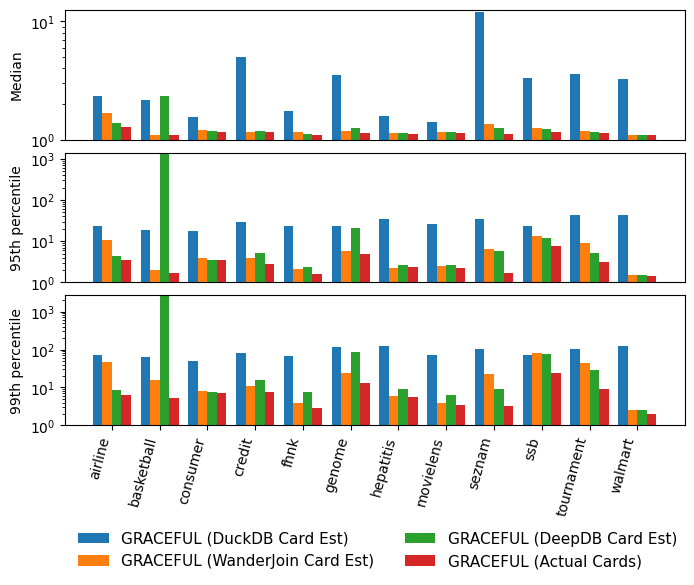

QError statistics (Avg. over all 20 datasets)
Card        q50        q95       q99    pushdown q50    pushdown q95    pushdown q99    pullup q50    pullup q95    pullup q99    intermed q50    intermed q95    intermed q99
------  -------  ---------  --------  --------------  --------------  --------------  ------------  ------------  ------------  --------------  --------------  --------------
act     1.13623    3.06375    7.4697         1.19697         3.44908         16.5558       1.09569       1.48564       2.01755         1.10877         1.61545         2.86961
dd      1.28695  117.99     232.496          1.30009       148.4            229.579        1.24557      62.6976      231.011           1.11363         1.75926         2.77372
wj      1.2229     5.33342   22.5717         1.25179         5.13198        122.637        1.85436      14.5823       29.3099          1.13083         1.71341         2.60085
est     3.45325   28.6243    86.6787         3.82795        27.1623          74

In [4]:
from collections import defaultdict
import tabulate
import numpy as np

labels = []
import matplotlib.pyplot as plt
import matplotlib

# create barplot with both lists
plt.close()
fig, axs = plt.subplots(len(metrics), 1, figsize=(8, 1.8*len(metrics)))

card_list = [ 'est', 'wj', 'dd','act',]
error_dict = defaultdict(dict)
for card in card_list:
    for dataset, df in df_card_dict[card].items():
        if len(df)==0:
            print(f'Empty dataframe for {card} card and {dataset} dataset')
            continue
        assert len(df)>0, f'Empty dataframe for {card} card and {dataset} dataset'
        
        per_dataset_errors = dict()
    
        for metric in metrics:
            
            error = metric.evaluate_metric(df['label'], df['pred'])
            per_dataset_errors[metric.name] = error
    
        error_dict[card][dataset] = per_dataset_errors

error_dict_by_file = dict()
for card in card_list:
    for dataset, file_dict in df_card_dict_by_file[card].items():
        for file, df in file_dict.items():
            if file not in error_dict_by_file:
                error_dict_by_file[file] = defaultdict(dict)

            if len(df)==0:
                print(f'Empty dataframe for {card} card and {dataset} dataset')
                continue
            assert len(df)>0, f'Empty dataframe for {card} card and {dataset} dataset'

            per_dataset_errors = dict()

            for metric in metrics:
                error = metric.evaluate_metric(df['label'], df['pred'])
                per_dataset_errors[metric.name] = error

            error_dict_by_file[file][card][dataset] = per_dataset_errors

dataset_list = sorted(list(set([dataset for card,vals in error_dict.items() for dataset in vals.keys()])))
barWidth = 1 / (len(error_dict) + 1)

x = np.arange(len(dataset_list))

label_dict = {
    'dd': 'GRACEFUL (DeepDB Card Est)',
    'est': 'GRACEFUL (DuckDB Card Est)',
    'act': 'GRACEFUL (Actual Cards)',
    'wj': 'GRACEFUL (WanderJoin Card Est)'
}

metric_dict = {
    'QError(median)': 'Median',
    'QError(95th percentile)': '95th percentile',
    'QError(99th percentile)': '99th percentile',
    'QError(max)': 'Max'
}

label_lookup={
    'carcinogenesis':'carc',

}

matplotlib.rcParams.update({'font.size':11})
for axs_id,metric in enumerate(metrics):
    metric_name = metric.name

    ax = axs[axs_id]
    
    for i, card  in enumerate(card_list):
        ax.bar(x + i * barWidth, [error_dict[card][dataset][metric_name] if dataset in error_dict[card] else np.nan for dataset in dataset_list], width=barWidth, label=label_dict[card])

    # if axs_id == len(metrics) - 1:
    #     ax.set_xlabel(f'Datasets')
    ax.set_ylabel(metric_dict[metric_name])

    # translate labels
    labels = [label_lookup[dataset] if dataset in label_lookup else dataset for dataset in dataset_list]

    if axs_id == len(metrics) - 1:
        ax.set_xticks(np.arange(len(labels)) + (len(card_list) - 1) / 2 * barWidth)
        ax.set_xticklabels(labels, rotation=75, ha='right')
    else:
        # do not show xticks labels
        ax.set_xticks([])

    # set title
    # ax.set_title(f'{metric.name} for different datasets')

    max_vals = {
        'QError(median)': 4,
        'QError(95th percentile)': 20,
        'QError(99th percentile)': 150,
        'QError(max)': 500
    }

    errors = [per_dataset_errors[metric_name] for card, per_card_erors in error_dict.items() for dataset, per_dataset_errors in per_card_erors.items()]# if card != 'est']
    errors = [e for e in errors if not np.isnan(e)]
    ax.set_yscale('log')
    ax.set_ylim(1,max(errors)*1.05)
    # ax.set_ylim(1, min(max_vals[metric.name] if metric.name in max_vals else np.inf,
    #                    max(errors) * 1.05))

    # reduce space between subplots
    plt.subplots_adjust(hspace=0.1)

    # place legend below chart
    if axs_id == len(metrics) - 1:
        ax.legend(ncol=2, loc='lower left', bbox_to_anchor=(0.0, -1.21), prop={'size': 11}, frameon=False)

# add space between subplots
# plt.tight_layout()

plt.show()
fig.savefig('results/cost_est_per_datasets_qerror_barchart.pdf', bbox_inches='tight')

lookup = {
    'QError(median)': 'q50',
    'QError(95th percentile)': 'q95',
    'QError(99th percentile)': 'q99',
}

card_list = [ 'act', 'dd', 'wj','est',]
tabulate_data = []
for card in card_list:
    row_data = [card]
    row_headers = ['Card']
    for metric in metrics:
        row_headers.append(lookup[metric.name])
        metric_name = metric.name
        
        errors = [error_dict[card][dataset][metric_name] for dataset in dataset_list if dataset in error_dict[card]]
        avg = sum(errors) / len(errors)
        row_data.append(avg)

    for file in ['pushdown', 'pullup','intermed']:
        for metric in metrics:

            row_headers.append(f'{file} {lookup[metric.name]}')
            metric_name = metric.name

            errors = [error_dict_by_file[file][card][dataset][metric_name] for dataset in dataset_list if dataset in error_dict_by_file[file][card]]
            avg = sum(errors) / len(errors)
            row_data.append(avg)
    
    tabulate_data.append(row_data)

print('QError statistics (Avg. over all 20 datasets)')
print(tabulate.tabulate(tabulate_data, headers=row_headers))

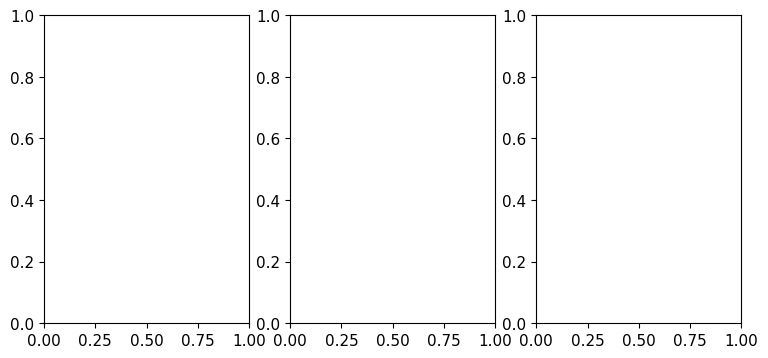

interactive(children=(Dropdown(description='slice_by_col', options=('label', 'pred', 'sample_idxs', 'sql', 'nu…

In [5]:
from matplotlib import gridspec
from typing import List
from ipywidgets import interact
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

def determine_slice_by_keys(vals, equi_width:bool=True, num_bins = 4):
    # Identify the unique values in the slice_by array
    unique_slicing_vals = np.unique(vals)

    if len(unique_slicing_vals) > num_bins and (
            isinstance(unique_slicing_vals[0], np.int64) or isinstance(unique_slicing_vals[0], np.float64)):
        try:
            max_slicing_val = math.ceil(max(unique_slicing_vals))
        except Exception as e:
            print(e)
            max_slicing_val = 0
            raise e
        # too many unique values, bin values
        if equi_width:
            bin_edges = np.linspace(0, max_slicing_val, num_bins)
        else:
            # equi-depth binning
            bin_edges = np.percentile(vals, np.linspace(0, 100, num_bins+1))
        slice_by_bin_id = np.digitize(vals, bin_edges, right=True)
        slice_by = bin_edges[slice_by_bin_id]
        unique_slicing_vals = np.unique(slice_by)
        digitize = True
    else:
        digitize = False
        bin_edges = None

    return unique_slicing_vals, digitize, bin_edges


def digitize_vals_to_slice_by(vals, bin_edges):
    slice_by_bin_id = np.digitize(vals, bin_edges, right=True)
    slice_by = bin_edges[slice_by_bin_id]

    return slice_by

@interact(slice_by_col=df_cols, card=['act', 'est', 'dd', 'wj'], average_across_datasets=[True, False], out_path=[''])
def slice(slice_by_col, card, average_across_datasets: bool = True, paper_plot=False, x_offset=0, y_offset = 0, equi_width:List=[],slices:List=[], int_bins=False, height_factor:float=4, width_factor:float=3, out_path:str=None, markup_revision:bool=False, hspace:float=0.65, wspace:float=0.45):
    if isinstance(slice_by_col, list):
        slice_by_col_list = slice_by_col
        int_bins_list = int_bins
        slices_list = slices
    else:
        slice_by_col_list = [slice_by_col]
        int_bins_list = [int_bins]
        slices_list = [slices]
    
    plt.close()
    if average_across_datasets:
        if paper_plot:
            fig = plt.figure(figsize=(len(slice_by_col_list)*width_factor, height_factor*len(metrics)))
            gs = gridspec.GridSpec(len(slice_by_col_list), len(metrics), figure=fig,hspace=hspace,wspace=wspace)

            axs = []
            for i in range(len(slice_by_col_list)):
                ax_row  =[]
                for j in range(len(metrics)):
                    ax_row.append(fig.add_subplot(gs[i, j]))
                    if i ==2:
                        pos = ax_row[-1].get_position().bounds
                        ax_row[-1].set_position([pos[0],pos[1]+0.05,pos[2],pos[3]])
                axs.append(ax_row)
        else:
            fig, axs = plt.subplots(len(slice_by_col_list), len(metrics), figsize=(len(metrics)*width_factor, height_factor*len(slice_by_col_list)))
    else:
        assert len(slice_by_col_list) == 1, 'Only one slice_by_col allowed when not averaging across datasets - otherwise chart gets too large'
        fig, axs = plt.subplots(len(metrics), 1, figsize=(len(metrics)*4, 12))
    
    if isinstance(card, list):
        assert average_across_datasets
        card_list = card
    else:
        card_list = [card]
    assert len(card_list)>0
    
    for axs_row in range(len(slice_by_col_list)):
        slice_by_col = slice_by_col_list[axs_row]
        int_bins = int_bins_list[axs_row]
        slices = slices_list[axs_row]
        if len(equi_width)>0:
            ew = equi_width[axs_row]
        else:
            ew=True
    
        slice_vals = dict()
        
        if slices is None or len(slices)==0:
            for c in card_list:
                slice_vals[c] = []
                for dataset, df in df_card_dict[c].items():
                    slice_vals[c].extend(df[slice_by_col].values)
                
                try:
                    avg = np.mean(slice_vals[c])
                    print(f'Average value of {slice_by_col}: {avg}')
                except Exception:
                    # print individual value counts
                    print(f'Value counts of {slice_by_col}:')
                    print(pd.Series(slice_vals[c]).value_counts())
        
            unique_slicing_vals, digitize, bin_edges = determine_slice_by_keys(slice_vals[c], equi_width=ew)
        else:
            unique_slicing_vals = slices
            digitize = True
            bin_edges = np.asarray(slices)
    
        error_dict = dict()
        for c in card_list:
            c_error_dict = dict()
            for dataset, df in df_card_dict[c].items():
                per_dataset_errors = dict()
        
                if digitize:
                    vals = digitize_vals_to_slice_by(df[slice_by_col].values, bin_edges)
                else:
                    vals = df[slice_by_col].values

                    if paper_plot:
                        # do here only a rough binning - each val should occur roughly the same amount of times
                        # count how often each element in vals occurs
                        val_counts = pd.Series(vals).value_counts()

                        # convert to dict mapping key : count
                        val_counts = val_counts.to_dict()
                        print(val_counts)

        
                # for each unique value, create a list of tuples (x,y) that have that value
                for value in unique_slicing_vals:
                    bool_arr = vals == value
                    pred_slice = df['pred'][bool_arr]
                    label_slice = df['label'][bool_arr]
        
                    tmp = dict()
        
                    for metric in metrics:
                        if len(pred_slice) == 0:
                            error = np.nan
                        else:
                            if len(label_slice)<100 and isinstance(metric,QError) and metric.percentile==99:
                                # compute max instead in this case
                                error = QError(percentile=100).evaluate_metric(label_slice, pred_slice)
                            else:
                                error = metric.evaluate_metric(label_slice, pred_slice)

                        tmp[f'{metric.name}'] = (error, label_slice,pred_slice)
        
                    per_dataset_errors[value] = tmp
        
                c_error_dict[dataset] = per_dataset_errors
            error_dict[c] = c_error_dict
        
        if average_across_datasets:
            assert len(error_dict) == len(card_list), f'Number of cards must match number of error dictionaries: {len(error_dict)} vs {len(card)}'
            for c in error_dict.keys():
                avg_error_dict = dict()
                for value in unique_slicing_vals:
                    tmp = dict()
                    for metric in metrics:
                        median_per_dataset = True
                        if not median_per_dataset:
                            # don't use this - attempt to fix underrepresentation problem when plotting
                            # extract unified labels and preds
                            preds = [error_dict[c][dataset][value][metric.name][2] for dataset in error_dict[c].keys()]
                            labels = [error_dict[c][dataset][value][metric.name][1] for dataset in error_dict[c].keys()]

                            # concatenate all labels and preds
                            labels = np.concatenate(labels)
                            preds = np.concatenate(preds)

                            error = metric.evaluate_metric(labels, preds)
                            tmp[metric.name] = error
                        else:
                            # median per dataset -> then avg
                            errors = [error_dict[c][dataset][value][metric.name][0] for dataset in error_dict[c].keys()]
                            errors = [e for e in errors if not np.isnan(e)]
                            if len(errors)==0:
                                tmp[metric.name]=-1
                            else:
                                tmp[metric.name] = sum(errors) / len(errors)

                    avg_error_dict[value] = tmp
                error_dict[c] = {None: avg_error_dict}
    
        for j, metric in enumerate(metrics):
            if len(slice_by_col_list) > 1:
                ax = axs[axs_row][j]
            else:
                ax = axs[j]
            
            if len(card_list) > 1:
                bar_width = 1/(len(card_list)+1)
            else:
                bar_width= 1/(len(error_dict[c].keys())+1)
                
            i = 0
            assert len(error_dict)==len(card_list), f'Number of cards must match number of error dictionaries: {len(error_dict)} vs {len(card_list)}'
            for card, er in error_dict.items():
                for dataset, errors in er.items():
                    x = np.arange(len(errors.keys()))
                    x = x + i * bar_width
                    
                    if average_across_datasets:
                        label = card
                    else:
                        label = dataset
                        
                    label_lookup = {
                        'dd': 'GRACEFUL (DeepDB Est. Cards)',
                        'act': 'GRACEFUL (Actual Cards)',
                    }
                    color_lookup = {
                        'dd': '#2ca02c',
                        'act': '#d62728',
                    }
                    
                    if label in color_lookup:
                        color = color_lookup[label]
                    else:
                        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
                        color = colors[i]
                    
                    if label in label_lookup:
                        label = label_lookup[label]
                        
                    tmp = [errors[val][metric.name] for val in errors.keys()]
                    ax.bar(x, tmp,label=label, width=bar_width, color=color)
                    print(x,tmp)
                    
                    i+= 1
            
            xlabel_dict= {
                'udf_num_comp_nodes':'Graph Size (Number of COMP nodes)',
                'udf_num_branches':'Number of Branches',
                'udf_num_loops':'Number of Loops',
            }
            
            if j == int(len(metrics)/2):
                if slice_by_col in xlabel_dict:
                    ax.set_title(f'{xlabel_dict[slice_by_col]}')
                else:
                    ax.set_title(f'{slice_by_col}')
            
            if paper_plot:
                tmp = {
                    'QError(median)': 'Median (Q-Error)',
                    'QError(95th percentile)': '95th percentile',
                    'QError(99th percentile)': '99th percentile',
                }
                if metric.name in tmp:
                    ax.set_ylabel(tmp[metric.name])
                else:
                    ax.set_ylabel(metric.name)
            else:
                ax.set_xlabel('Dataset')
                ax.set_title(f'{metric.name} error for {card} card')
                ax.set_ylabel(f'{metric.name}')
            
            # if slice_by_col in xlabel_dict:
            #     ax.set_xlabel(xlabel_dict[slice_by_col])
            # else:
            #     ax.set_xlabel(slice_by_col)
            # if paper_plot:
            #     ax.set_title(f'{metric.name}')
            # else:
            #     ax.set_title(f'{metric.name} error for {card} card')
            #     ax.set_ylabel(f'{metric.name}')
    
            xticklabels=[]
            for i in range(len(unique_slicing_vals)):
                if isinstance(unique_slicing_vals[i], str):
                    xticklabels.append(unique_slicing_vals[i])
                elif not digitize:
                    xticklabels.append(f'{unique_slicing_vals[i]}')
                else:
                    if i > 0:
                        if int_bins:
                            xticklabels.append(f'{unique_slicing_vals[i-1]}-{unique_slicing_vals[i]}')
                        else:
                            xticklabels.append(f'{unique_slicing_vals[i-1]:.2f}-{unique_slicing_vals[i]:.2f}')
                    else:
                        if int_bins:
                            xticklabels.append(f'0 - {unique_slicing_vals[i]}')
                        else:
                            xticklabels.append(f'0 - {unique_slicing_vals[i]:.2f}')
            
            # only do rotation if labels are long
            ax.set_xticks(np.arange(len(unique_slicing_vals))+(len(error_dict)-1)/2 * bar_width)
            if max([len(l) for l in xticklabels]) > 3:
                ax.set_xticklabels(xticklabels, rotation=45, ha='right')
                if markup_revision:
                    # set color to blue
                    ax.tick_params(axis='x', colors='blue')
            else:
                ax.set_xticklabels(xticklabels)
    
            # min y = 1
            tmp = [error_dict[c][dataset][val][metric.name] for c, er in error_dict.items() for dataset, errors in er.items() for val in errors.keys()]
            tmp = [e for e in tmp if not np.isnan(e)]
            ax.set_ylim(1, max(tmp) * 1.05)
            
            # if paper_plot:
            #     if j == 1 and axs_row == len(slice_by_col_list)-1:
            #         ax.legend(ncol=2, loc='lower left', bbox_to_anchor=(-.1, -0.2-y_offset),frameon=False)
            # else:
            #     if len(error_dict.keys()) > 1:
            #         # place legend below chart
            #         ax.legend(ncol=2, loc = 'upper left',bbox_to_anchor=(1, 1))
    
    if len(slice_by_col_list)>1:
        legend_handles, legend_labels = axs[0][0].get_legend_handles_labels()
    else:
        legend_handles, legend_labels = axs[0].get_legend_handles_labels()
    if paper_plot:
        fig.legend(legend_handles, legend_labels, ncol=2, loc='lower center', bbox_to_anchor=(x_offset, y_offset),frameon=False)
    else:
        if len(error_dict.keys()) > 1:
            # place legend below chart
            fig.legend(legend_handles, legend_labels, ncol=2, loc = 'lower center',bbox_to_anchor=(1, 1))
    
    # Add letters to the subplots
    for plot, letter in zip(list(axs), "ABCDEFG"):
        plot[0].annotate(
            letter,
            xy=(-0.15, 1.10),
            xycoords='axes fraction',
            fontsize=9,
            ha='center',
            va='center',
            bbox=dict(boxstyle='circle,pad=0.2', edgecolor='black', facecolor='white'))      

    if paper_plot:
        plt.tight_layout()
    plt.show()
    
    if out_path is not None:
        fig.savefig(out_path, bbox_inches='tight')

80   -1.432261
57   -0.266381
Name: pred, dtype: float64 (labels: 54    19.588591
80    17.681652
57     9.621252
Name: label, dtype: float64)
23    -0.418246
24   -29.122639
81    -0.288328
16    -0.363369
24    -0.984066
26   -10.815127
62    -1.834648
Name: pred, dtype: float64 (labels: 3     25.848366
23    24.687698
24     9.002431
81    22.224770
16    17.346682
24    24.436300
26     3.082319
62     2.265229
Name: label, dtype: float64)
134     -0.583716
160     -0.976459
173     -0.245794
27      -5.780394
29    -134.440933
49     -11.858875
Name: pred, dtype: float64 (labels: 107    18.317924
134     2.241883
160    25.202158
173    27.486132
27     19.729605
29      3.962149
49     14.783417
Name: label, dtype: float64)
Name: pred, dtype: float64 (labels: 9    25.476809
Name: label, dtype: float64)
Name: pred, dtype: float64 (labels: 12    7.576153
Name: label, dtype: float64)
[0. 1. 2. 3. 4.] [1.1592166376836366, 1.1321974863680497, 1.1383482477451963, 1.1364115062187565, 1.

/tmp/ipykernel_53477/3383184789.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


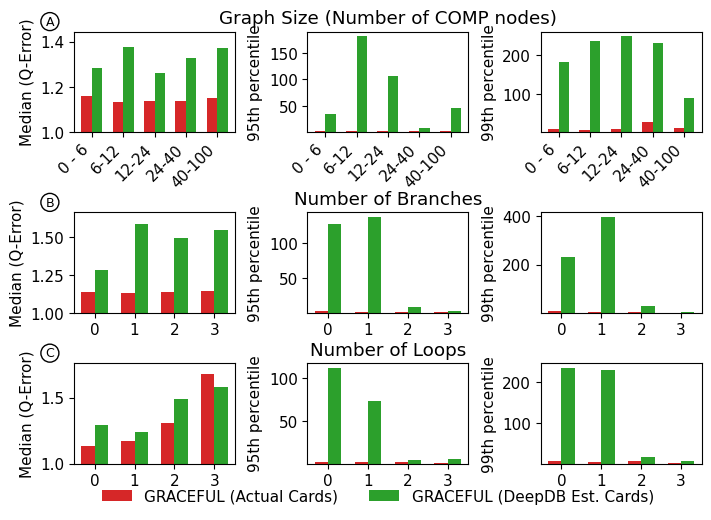

In [6]:
# === FINAL PAPER PLOTS ===
slice(['udf_num_comp_nodes','udf_num_branches','udf_num_loops',], ['act','dd'], True, paper_plot=True, y_offset=0.07, x_offset=0.5, equi_width = [True,True,True],slices=[[6,12,24,40,100],None, None,], int_bins=[True,True,True], height_factor=2,
      width_factor=2.7, out_path='results/error_over_multiplot.pdf',markup_revision=False, hspace=0.8)
# === END ====

Average value of label: 10.0490075066597
Name: pred, dtype: float64 (labels: 57    28.62952
Name: label, dtype: float64)
[0. 1. 2.] [1.2749750549075987, 1.1860470552807707, 1.1482494364887181]
[0. 1. 2.] [5.911658054906447, 6.8466903274065904, 4.381878968849345]
[0. 1. 2.] [25.869325393363415, 19.205891831463333, 271.0862781504855]


TypeError: 'Axes' object is not subscriptable

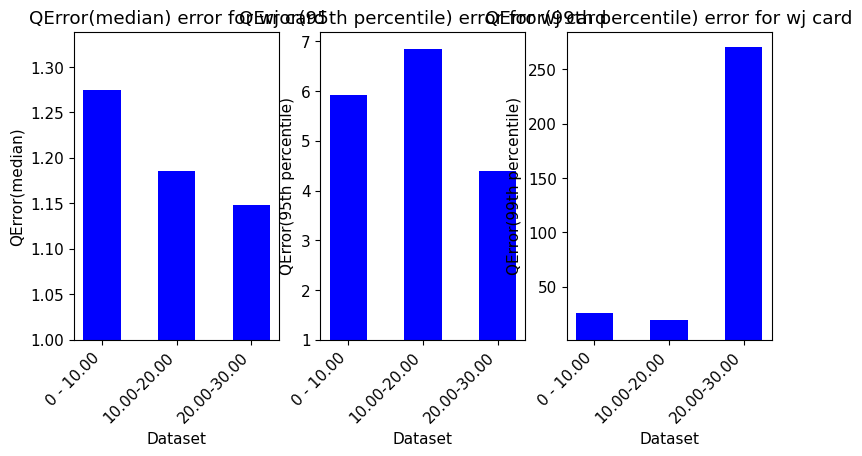

In [7]:
slice('label', 'wj', True)
slice('udf_num_np_calls', 'wj', True)
slice('udf_num_math_calls', 'wj', True)
slice('udf_num_comp_nodes', 'wj', True)
slice('udf_num_branches', 'wj', True)
slice('udf_num_loops', 'wj', True)
slice('udf_pos_in_query', 'wj', True)